In [1]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Pkg
using IJulia
using Distributions
using Plots

In [2]:
include("../Test Models/COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

normal setup (nurses_days_per_patient_day_covid)

In [224]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [147]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)
travel_threshold_hours = 6.0
hospitalized_days = ceil(mean(Weibull(1.38,12.88)));

In [148]:
N = length(states);
T = (end_date - start_date).value + 1

forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date,  end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), end_date-Dates.Day(hospitalized_days),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);
#forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days));

In [149]:
#beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available);
adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

This chunk is made to adjust the nurses-patients ratio

! I have only played with nurses weekly hours so far and plotted the shortage over time.
!! Maybe tried tuning pct_nurses_available as well because this will directly affect nurses data

In [207]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 48

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 6.857142857142857
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 3.5
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.4


In [208]:
nurses = n_nurses(states) * Float32(pct_nurses_available);

(DONT NEED TO DO THIS NOW)Plot the forecasted active patients over time by state to better choose the length of time for isolation

In [ ]:
# start_date_new = Date(2020, 3, 30)
# end_date_new   = Date(2020, 5, 1)
# date_range = start_date_new:end_date_new
# states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
# states_cleaned = [replace(state, r"[, ]" => "") for state in states]
# states_cleaned_row = hcat(states_cleaned...)

# # # check the shortage matrix
# # # size(shortage_matrix)
# start = (start_date_new - start_date).value+1
# t_length = (end_date_new - start_date_new).value
# df = forecast_active[:,start:start+t_length]

# plot(date_range,[vec(df[i,:]) for i in 1:size(df)[1]],
#      xlabel = "Date",
#      ylabel = "Forecasted Active Patients By State",
#      title = "Forecasted Active Patients over Time",
#      legend = :topright,
#      label = states_cleaned_row,
#      linewidth = 2,
#      fmt=:png)

# #savefig(joinpath("../figures", "Forecasted_Active_Patients_Overtime.png"))


Always run this chunk to initialize all the following tables first before running the model!! 

In [225]:
## create arrays to store all the model output
# total amount
nurses_sent_tot = zeros(T)
shortage_tot = zeros(T)
average_load = zeros(T)
patients_sent_tot = zeros(T)
overall_shortage = zeros(T)
patient_sent_matrix = zeros(Int, N, N)
nurse_sent_matrix = zeros(Int, N, N)
summary_model = DataFrame(
        state = states,
        total_sent = 0,
        total_received = 0,
        initial_nurses = 0,
        total_nurse_days = 0,
        total_demand = 0,
        total_shortage = 0,
        average_load = 0)
complete_model = DataFrame(
        state = Any[],
        date = Any[],
        sent = Any[], 
        received = Any[],
        current_nurses = Any[],
        demand = Any[],
        shortage = Any[]);
       


MODEL!!!

In [226]:
contaminated_hospitals = vec([0,0,0,0,0,0,1,1,0,0,0])
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)

stage1_matrix = copy(adj)

        for i in 1:N  
            for j in 1:N 
                # check that the edge is directed toward the contaminated hospital
                # if true set the matrix idx to 1 else leave it as 0 
                stage1_matrix[i,j] = (contaminated_hospitals[j] == 1)
            end
        end
        
    stage2_matrix = copy(adj)
    for i in 1:N  
        for j in 1:N 
            if contaminated_hospitals[i] == 1 || contaminated_hospitals[j] == 1
                stage2_matrix[i,j] = 0
            end
        end
    end

demand = forecast_active * nurse_days_per_patient_day_covid

for t in 1:Int(ceil((T-1)/2))
    #indices = findall(x -> x == 1, contaminated_hospitals)
    model1 = reusable_resource_allocation(
        nurses,
        zeros(Float32, size(demand[:, t:t+1])...),
        demand[:, t:t+1],
        stage1_matrix,
        obj_dir = :shortage,  
        send_new_only = false,
        sendrecieve_switch_time = 0,
        min_send_amt = 0,
        smoothness_penalty = 0,
        setup_cost = 0,
        sent_penalty = 0.01,
        verbose = true
    );

    sent_nurses_contam = value.(model1[:sent])
    #indices = findall(x -> x == 1, contaminated_hospitals)
    received_by_contaminated = [sum(sent_nurses_contam[:, j, :]) for j in 1:length(contaminated_hospitals)]
    sent_to_contaminated = [sum(sent_nurses_contam[j, :, :]) for j in 1:length(contaminated_hospitals)]
    nurses_afterstage1 = nurses-sent_to_contaminated+received_by_contaminated

    model1_result = NurseAllocationResults.results_all(sent_nurses_contam, nurses, demand[:, t:t+1], states, start_date)
    # stage1_shortage_tot = model1_result.total_shortage
    # stage1_average_load = model1_result.average_load
    summary1 = model1_result.summary_table

    nurses_sent_tot[t] = sum(sent_nurses_contam)

    forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
    )[:]

    model2 = patient_nurse_allocation(
        forecast_initial,#demand[:, t:t+1],#nurses_afterstage1, 
        forecast_discharged[:, t:t+1],
        forecast_admitted[:, t:t+1],
        nurses_afterstage1,
        stage2_matrix,
        smoothness_penalty = 0.01,
        los=Weibull(1.38,12.88),
        nurse_days_per_patient_day = nurse_days_per_patient_day_covid,
        verbose =true
    );

    sent_nurses_uncontam = value.(model2[:sentnurses])
    sent_patients_uncontam = value.(model2[:sentpatients])
    #indices = findall(x -> x == 0, contaminated_hospitals)
    receivedn_by_uncontaminated = [sum(sent_nurses_uncontam[:, j, :]) for j in 1:length(contaminated_hospitals)]
    sentn_to_uncontaminated = [sum(sent_nurses_uncontam[j, :, :]) for j in 1:length(contaminated_hospitals)]
    receivedp_by_uncontaminated = [sum(sent_patients_uncontam[:, j, :]) for j in 1:length(contaminated_hospitals)]
    sentp_to_uncontaminated = [sum(sent_patients_uncontam[j, :, :]) for j in 1:length(contaminated_hospitals)]

    nurses = nurses_afterstage1-sentn_to_uncontaminated+receivedn_by_uncontaminated
    demand[:,t+1] .+= (receivedp_by_uncontaminated - sentp_to_uncontaminated) *  nurse_days_per_patient_day_covid

    nurses_sent_tot[t] += sum(sent_nurses_uncontam)
    patients_sent_tot[t] = sum(sent_patients_uncontam)

    #model2_presult = PatientAllocationResults.results_all(sent_patients_uncontam, nurses_afterstage1, forecast_initial, forecast_admitted[:, t:t+1], forecast_discharged[:, t:t+1], states, start_date, Weibull(1.38,12.88));
    model2_nresult = NurseAllocationResults.results_all(sent_nurses_uncontam, nurses_afterstage1, demand[:, t:t+1], states, start_date)

    summary2 = model2_nresult.summary_table

    summary_model.total_sent += summary1.total_sent + summary2.total_sent
    summary_model.total_received += summary1.total_received + summary2.total_received
    summary_model.initial_nurses = summary2.initial_nurses
    summary_model.total_nurse_days = summary2.total_nurse_days
    summary_model.total_demand += summary2.total_demand
    summary_model.total_shortage += summary2.total_shortage
    #summary_model.average_load = (summary1.average_load * nurses_afterstage1 + summary2.average_load * nurses)/2
    
    complete1 = model1_result.complete_table[:,["state","date","sent", "received","current_nurses","demand","shortage"]]
    complete2 = model2_nresult.complete_table[:,["state","date","sent", "received","current_nurses","demand","shortage"]]

    sent_byTime = complete1.sent + complete2.sent 
    received_byTime = complete1.received + complete2.received
    #demand_byTime = complete2.demand
    #shortage_byTime = complete2.shortage
    
    complete_currentstage = copy(complete2)
    complete_currentstage.sent = sent_byTime
    complete_currentstage.received = received_byTime

    if isempty(complete_model)
        complete_model = copy(complete_currentstage)
    else
        complete_model = vcat(complete_model, complete_currentstage)
    end

    stage2_shortage_tot = model2_nresult.total_shortage
    stage2_average_load = model2_nresult.average_load 

    overall_shortage[t] = stage2_shortage_tot
    average_load[t] = stage2_average_load
    
    start_date = start_date + Dates.Day(2)

    t+=2
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 385 rows, 264 columns and 1386 nonzeros
Model fingerprint: 0x8d3fb676
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+04]
Presolve removed 385 rows and 264 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8069718e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.806971844e+01

User-callback calls 39, time in user-callback 0.00 sec
Set parameter Username
Academic license - for non-commercial u

In [227]:
complete_model

Row,state,date,sent,received,current_nurses,demand,shortage
,String,Date,Float64,Float64,Float64,Float64,Float64
1,CT,2020-03-30,38.9979,0.0,967.538,716.181,0.0
2,CT,2020-03-31,0.0,36.69,1004.23,855.55,0.0
3,DE,2020-03-30,0.0,0.0,181.484,59.2359,0.0
4,DE,2020-03-31,36.69,0.0,144.794,64.7941,0.0
5,MA,2020-03-30,0.0,0.0,1029.21,363.923,0.0
6,MA,2020-03-31,0.0,0.0,1029.21,430.672,0.0
7,MD,2020-03-30,0.0,0.0,1820.49,445.865,0.0
8,MD,2020-03-31,0.0,0.0,1820.49,540.659,0.0
9,ME,2020-03-30,0.0,0.0,40.2687,37.7112,0.0


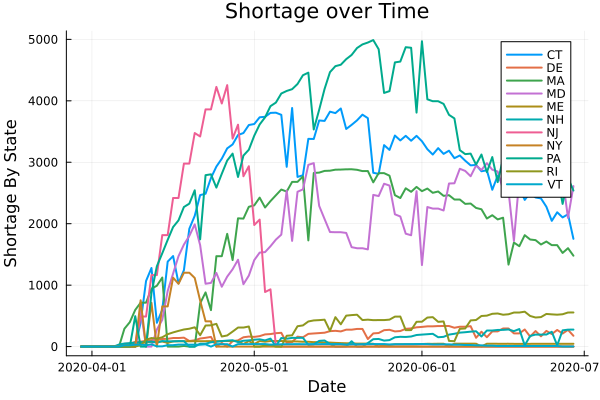

In [228]:
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 29)
date_range = start_date:end_date
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = complete_model
cleaned_df = DataFrame(State=df.state, Date=df.date, Shortage=df.shortage)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
shortage_matrix = zeros(11, 92)
for (i, state_df) in enumerate(grouped_df)
    shortage_matrix[i, :] .= state_df.Shortage
end

# # check the shortage matrix
# # size(shortage_matrix)

plot(date_range,[vec(shortage_matrix[i,:]) for i in 1:size(shortage_matrix)[1]],
     xlabel = "Date",
     ylabel = "Shortage By State",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

# remember to include the nurse patient ratio in the file name
#savefig(joinpath("../figures", "Contagion_shortage_1.86_plot.png"))


In [230]:
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 29)
date_range = start_date:end_date
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = complete_model
cleaned_df = DataFrame(State=df.state, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, 92)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# # check the shortage matrix
# # size(shortage_matrix)

plot(date_range,[vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Total Nurse Transfer By State",
     title = "Nurse Transfer over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)

savefig(joinpath("../figures", "Contagion_NTransfer1.86_plot.png"))


"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/Contagion_NTransfer1.86_plot.png"